# Acquisition functions in Bayesian optimization

The acquisition $\alpha_t(x)$ quantifies how useful a point $x$ is towards finding the global optimum of the objective $y^*$, thus we want to maximize it at each step $t=1 ... T$.  
$D_t = \{(x_1, y_1) ... (x_t, y_t)\}$ is the data, of which $x^+$ is the location of the best point $y^+$ observed so far.  

The values for the objective function are typically modelled by $y_t = f(x_t) + \epsilon_t$ where the $\epsilon_t \sim N(0,\sigma)$ and $f$ is a probabilistic surrogate model. In case of a Gaussian Process the posterior predictive distribution can be expressed in terms of a mean $\mu_f$ and variance $\sigma_f^2$.

### Single objective
* Upper confidence bound [UCB]: [Auer 2002]() [Srinivas+ 2010 - Gaussian Process Optimization in the Bandit Setting: No Regret and Experimental Design](https://arxiv.org/abs/0912.3995)
* Probability of improvement [PI]: [Kushner 1964 A new method of locating the maximum point of an arbitrary multipeak curve in the presence of noise](https://fluidsengineering.asmedigitalcollection.asme.org/article.aspx?articleid=1431594)
* Expected improvement [EI]: [Mockus 1974, On Bayesian Methods for Seeking the Extremum](https://link.springer.com/content/pdf/10.1007/3-540-07165-2_55.pdf)
* Top-two expected improvement [TTEI]: [Qin+ 2017, Improving the Expected Improvement Algorithm](https://arxiv.org/abs/1705.10033)
* Scaled expected improvement [SEI]: [Noe 2018 - On a New Improvement-Based Acquisition Function for Bayesian Optimization](https://arxiv.org/abs/1808.06918)
* Mutual information [GP-MI]: [Contal+ 2014 - Gaussian Process Optimization with Mutual Information](http://proceedings.mlr.press/v32/contal14.pdf)
* Entropy search [ES]: [Henning+ 2012 Entropy Search for Information-Efficient Global Optimization](https://arxiv.org/abs/1112.1217)
* Predictive entropy search [PES]: [Hernandez-Lobato+ 2014 Predictive Entropy Search for Efficient Global Optimization of Black-box Functions](https://arxiv.org/abs/1406.2541)
* Max-value entropy search [MES] [Wang 2018 - Max-value Entropy Search for Efficient Bayesian Optimization](https://arxiv.org/abs/1703.01968)
* Estimation strategy [EST]: [Wang+ 2016 - Optimization as Estimation with Gaussian Processes in Bandit Settings](https://arxiv.org/abs/1510.06423)
* Global optimisation with Look-Ahead through Stochastic Simulation and Expected-loss Search [GLASSES]: [Gonzales+ 2016 GLASSES: Relieving The Myopia Of Bayesian Optimisation](https://arxiv.org/abs/1510.06299)
* [SMAC]: [Hutter+ 2010 - Sequential Model-Based Optimization for General Algorithm Configuration](https://doi.org/10.1007/978-3-642-25566-3_40)
* [ROAR]: [Hutter+ 2010 - Sequential Model-Based Optimization for General Algorithm Configuration](https://doi.org/10.1007/978-3-642-25566-3_40)
* Knowledge gradient [KG]: [Frazier+ 2009 - The knowledge-gradient policy for correlated normal beliefs](https://pubsonline.informs.org/doi/abs/10.1287/ijoc.1080.0314)
* [GP-KG]: [Scott+ 2011 - The Correlated Knowledge Gradient for Simulation Optimization of Continuous Parameters using Gaussian Process Regression](https://epubs.siam.org/doi/10.1137/100801275)

### Multiple objectives
In the case of multiple objectives there are two approaches: 
1) multi-objective scalarization with either a-priori chosen or random weights, together with a single-objective acquisition 
2) multi-objective acquistions that aim for improving the knowledge of the Pareto front.

Regarding 1) the same scalarizations as in multi-objective optimization may be applied. An overview of scalarization methods with respect to Bayesian optimization is given in [Chugh 2019 - Scalarizing Functions in Bayesian Multiobjective Optimization](https://arxiv.org/abs/1904.05760).

Regarding 2) there is a growing list of multi-objective acquistions:
* Hypervolume contribution [SMS]
* S-metric-based Expected Improvement [SExI]
* Expected hypervolume contribution [EHVI]: [Emmerich 2005 - Single- and Multi-objective Evolutionary Design Optimization Assisted by Gaussian Random Field Metamodels](https://d-nb.info/998357294/34)
* Expected maximin [EMmi]: [Svenson+ 2016 - Multiobjective optimization of expensive-to-evaluate deterministic computer simulator models](https://www.sciencedirect.com/science/article/pii/S0167947315001991)
* Probability of improvement, Expected Euclidean improvement [Keane 2012 - Statistical Improvement Criteria for Use in Multiobjective Design Optimization](https://arc.aiaa.org/doi/abs/10.2514/1.16875?journalCode=aiaaj)
* Predictive entropy search [Garrido-Merchan+ 2019 - Predictive Entropy Search for Multi-objective Bayesian Optimization with Constraints](https://www.sciencedirect.com/science/article/pii/S0925231219308525)
* Uncertainty reduction [Picheny 2015 - Multiobjective optimization using Gaussian process emulators via stepwise uncertainty reduction](https://link.springer.com/article/10.1007/s11222-014-9477-x)
* Thompson sampling [TS]: [Bradford 2018 - Efficient multiobjective optimization employing Gaussian
processes, spectral sampling and a genetic algorithm](https://doi.org/10.1007/s10898-018-0609-2)
* Chimera
* Expected R2 improvement [ER2I]: [Deutz 2019 - Expected R2 Indicator Improvement as an Infill Criterion in Bi-objective Bayesian Optimization](https://link.springer.com/chapter/10.1007/978-3-030-12598-1_29)
* Uncertainty sampling, Probability of Joint Exceedance, Hyperplane probability of improvement, Probability non-dominated: [Zachary+ (2019) Assessing the Frontier: Active Learning, Model Accuracy, and Multi-objective Materials Discovery and Optimization](https://arxiv.org/abs/1911.03224)

### Examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import GPy
import GPyOpt

In [2]:
# set up unknown test function
σ_noise = 0.5
np.random.seed(1337)
f_true = GPyOpt.objective_examples.experiments1d.forrester()
f_noisy = GPyOpt.objective_examples.experiments1d.forrester(sd=σ_noise)

X = np.linspace(0, 1, 201).reshape(201, 1)
Y = f_true.f(X)

# observed data
Xd = np.array([0.1, 0.5, 0.63, 0.92]).reshape([4, 1])
Yd = f_noisy.f(Xd)
best = Yd.min()

# fit Gaussian process
gp = GPy.models.GPRegression(Xd, Yd, kernel=GPy.kern.Matern52(1))
gp.optimize_restarts(10, verbose=0)

# GP posterior
μf, σf = gp.predict(X)
σf = σf ** 0.5

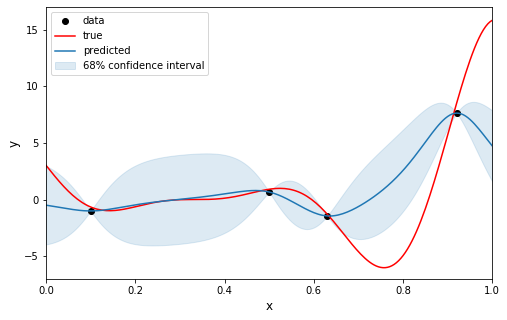

In [3]:
def plot(plot_true=False, acquisition=None):
    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.plot(Xd, Yd, 'ko', label='data')
    if plot_true:
        ax.plot(X, Y, 'r', label='true')
    ax.plot(X, μf, 'C0', label='predicted')
    ax.fill_between(X[:,0], (μf - σf)[:,0], (μf + σf)[:,0], alpha=.15, color='C0', label='68% confidence interval')
    ax.set(xlabel='x', ylabel='y', xlim=(0, 1), ylim=(-7, 17))
    ax.legend(loc='upper left')
    if acquisition is not None:
        ax2 = ax.twinx()
        ax2.plot(X, acquisition, 'C1', label='acquisition')
        ax2.legend(loc='upper right')
    
plot(True)

## Lower confidence bound
The idea is to be optimistic and simply look for the best value of the $k-$sigma confidence bound.  
$\alpha_\mathrm{CB}(x) = \mu_f(x) - k \sigma_f(x)$, where $\mu$ and $\sigma$ are the predictive mean and standard deviation, and $k$ controls the exploration. For a derivation see [SEI].

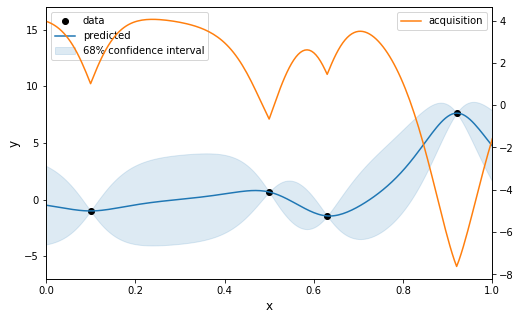

In [4]:
a = - (μf - σf)  # negative, since we maximize the acquisition
plot(acquisition=a)

## Probability of improvement
The idea is to select the point with the highest probability of any improvement $I(x) = \max(0, f^+ - f(x))$ is the improvement of the predicted value $f(x)$ wrt. $f^+$ the best value observed so far.   
$\alpha_\mathrm{PI}(x) = \mathbb{P}(I(x) > 0) = \Phi(u)$ where $u = (f^+ - \mu_f(x)) / \sigma_f(x)$ and $\Phi$ is the standard normal cdf. For a derivation see [SEI].

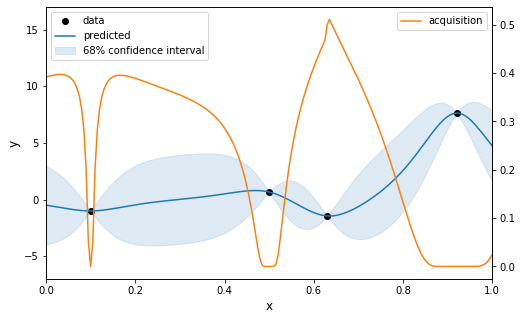

In [5]:
u = (best - μf) / σf
PI = scipy.stats.norm.cdf(u)
plot(acquisition=PI)

## Expected improvement
Instead of looking for any kind of improvement ($I(x) > 0$), we can take the magnitude of the improvement $I(x)$ into account, by maximizing the expected improvement:  
$\alpha_\mathrm{EI}(x) = \mathbb{E} [I(x)] = (f^+ - \mu_f(x)) \Phi(x) + \sigma_f(x) \phi(x)$, where $\Phi$ and $\phi$ are the standard normal cdf and pdf, respectively. For a derivation see [SEI].

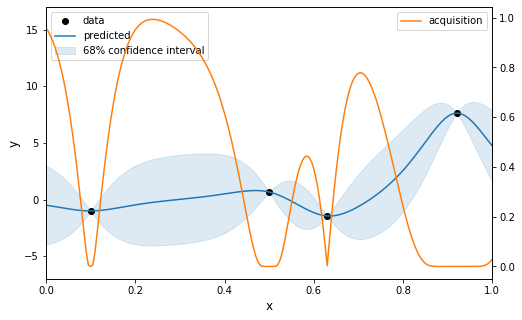

In [6]:
u = (best - μf) / σf
cdf = scipy.stats.norm.cdf(u)
pdf = scipy.stats.norm.pdf(u)
EI = (best - μf) * cdf + σf * pdf

plot(acquisition=EI)

## Scaled expected improvement
A recent modification of the expected improvement takes the uncertainty of the improvement quantifier $I(x)$ into account:
$\mathbb{V}[I(x)] = σ_f^2(x)((u^2 + 1) \Phi(u) + u \phi(u)) − \mathrm{EI}(x)^2$.  
Scaling the expectation value of $I(x)$ by its uncertainty, we arrive at
$\alpha_\mathrm{SEI} = \mathbb{E}[I(x)] / \sqrt{\mathbb{V}[I(x)]}$.

Comment: At least in this example SEI looks very similar to PI as dividing by the uncertainty of the improvement seems to cancel out the exploration part in EI. The authors claim superior empirical performance compared to both EI and PI on the standard set of low-dimensional optimization functions though ...

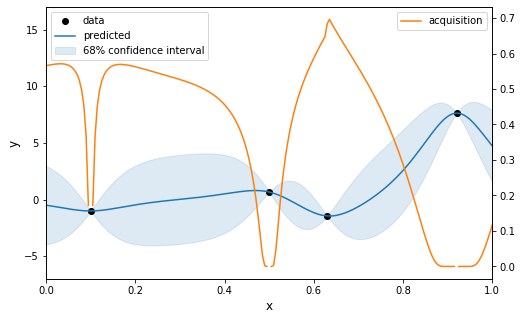

In [7]:
u = (best - μf) / σf
cdf = scipy.stats.norm.cdf(u)
pdf = scipy.stats.norm.pdf(u)
EI = (best - μf) * cdf + σf * pdf
V = σf**2 * ((u**2 + 1) * cdf + u * pdf) - EI**2
SEI = EI / V**0.5

plot(acquisition=SEI)

## Thompson sampling
In Thompson sampling, also known as probability matching, we simply draw a sample of the posterior predictive distribution and maximize this. For Gaussian processes there is no known way of drawing exact samples, hence approximate samples needs to be used instead, based on a finite vector of inputs x. In [PES] and [TSEMO] spectral sampling is proposed for this purpose.

## Entropy search
In a nutshell entropy search approximates the distribution of the global minimum and tries to best decrease it's entropy.  
$\alpha_{ES}(x) = H(p(x^*|\mathcal{D})) - E[H(p(x^*|\mathcal{D} \cup \{x, y\}))]$ where $x^*$ is the argmax of the global optimum. Since $x^*$ is unknown we need to derive it's distribution via sampling from the posterior.

## Predictive Entropy Search
$\alpha(x) = H(p(y|D_t,x)) - E[H(p(y|D_t, x, x_*))]$

## Max-value Entropy Search
The idea is to keep the information-theoretic approach, but reducing the computational complexity by searching for the max $y^*$ instead of the argmax $x^*$.  
$\alpha_\mathrm{MES}(x) = H(p(y|\mathcal{D},x)) - E[H(p(y|\mathcal{D}, x, y_*))]$ where in the left hand term $p$ is a Gaussian, an in the right hand term $p$ is a truncated Gaussian fullfilling $y \leq y^*$  
If the value of $y^*$ is known MES has closed form. If it is unknow it needs to be sampled. Next to sampling from the posterior the authors propose using a Gumbel distribution as approximation.  
$\alpha(x) = (y^* + |\mathcal{N}(0, \sigma)| - \mu_f(x)) / \sigma_f(x)$